In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pprint
import pickle
import json
import os, sys
os.chdir("../")
sys.path.append('src/')
from util import *
from train import train_instances

## Transitions table

In [ ]:
files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L", "5mill_C", "5mill_SL", "5mill_SL20", "5mill_JE", "5mill_JE20", "5mill_JEadam"]
old_files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L"]
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
for problem in problems:
    x = PrettyTable()
    x.field_names = [problem, "min 2", "min 3", "last q", "ra 2", "ra 3"]
    for file in files:
        if file in old_files:
            df_2_2 = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/"+filename([problem, 2, 2])+".csv")
            df_3_3 = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/"+filename([problem, 3, 3])+".csv")
            df_q = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/q.csv")
        else:
            df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
            df_2_2 = fill_df(df.loc[(df["n"]==2)&(df["k"]==2)].copy(), 15)
            df_3_3 = fill_df(df.loc[(df["n"]==3)&(df["k"]==3)].copy(), 15)
            
        min_2_2 = df_2_2["expanded transitions"].min()
        min_3_3 = df_3_3["expanded transitions"].min()
        
        ra_2_2 = ra_results["expanded transitions", problem][2][2]
        ra_3_3 = ra_results["expanded transitions", problem][3][3]
        last_q = -df_q.iloc[-1]["avg q"]
        x.add_row([file, min_2_2, min_3_3, last_q, ra_2_2, ra_3_3])
    print(x)

## Plotting Q

In [ ]:
problems = ["AT", "TA", "TL", "DP", "BW", "CM"]
for problem, n, k in [(x, 2, 2) for x in problems]:
    df = pd.read_csv("experiments/results 25 mar/"+filename([problem, n, k])+"/10m_0.csv")
    df["avg q"] = -df["avg q"]
    sns.lineplot(data=df, x="training time", y="avg q")
    
    plt.title(" ".join([problem, str(n), str(k), "q"]))
    
    plt.savefig("experiments/figures/10m_0/q/"+filename([problem, n, k])+".jpg", dpi=200)
    plt.show()

## Correlation 2 2 vs 3 3

4 4 AT was not solved (in 5s)


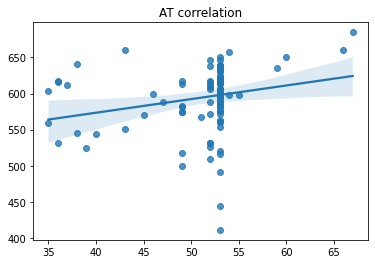

4 4 BW was not solved (in 5s)


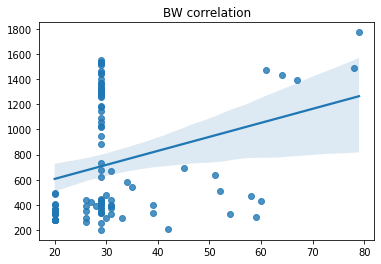

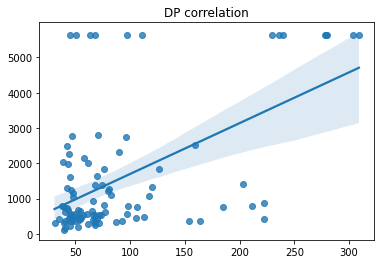

4 1 TA was not solved (in 5s)
4 2 TA was not solved (in 5s)
4 3 TA was not solved (in 5s)
4 4 TA was not solved (in 5s)


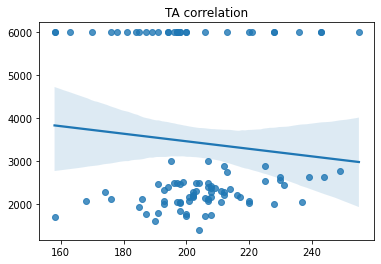

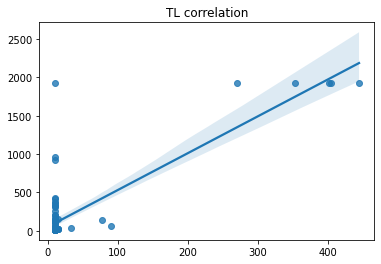

In [2]:
problems = ["AT", "BW", "DP", "TA", "TL"]

#files = ["1mill", "T_1mill", "B_1mill", "TB_1mill"]
#files = ["TB_5mill", "ra_feature2opt_2h", "base_features_2h"]
#files = ["ra_feature2opt_2h"]
file = "5mill_SL20"

for problem, n, k in [(x, 2, 2) for x in problems]:
    
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/generalization_all.csv")
    df = df.loc[(df["n"] <= 5) & (df["k"] <= 5)]
    l = [{} for idx in range(101)]
    for _, r in df.iterrows():
        if not np.isnan(r["expanded transitions"]):
            l[r["idx"]][r["n"], r["k"]] = r["expanded transitions"]
    i = 0
    for x, cant in dict(df["idx"].value_counts()).items():
        l[i]["solved"] = cant
        i+=1
    #print(l)
    for n in range(1, 5):
        for k in range(1, 5):
            others = [l[j][n, k] for j in range(101) if (n, k) in l[j].keys()]
            if len(others) > 0:
                for i in range(101):
                    if (n, k) not in l[i].keys():
                        l[i][n, k] = 2*np.max(others)
            else:
                print(n, k, problem, "was not solved (in 5s)")
    #print([l[i][2, 2] for i in range(101)])
    #print([l[i][3, 3] for i in range(101)])
    sns.regplot(x=[l[i][2, 2] for i in range(101)], y=[l[i][3, 3] for i in range(101)])
    plt.title(problem+" correlation")
    plt.show()

## Generalization fixing n or k

In [ ]:
#df1 = lambda problem: df_agent(problem, "all_ra_afterfix_15.csv")
df1 = lambda problem: df_agent(problem, "5mill_JE20/all.csv")
df2 = lambda problem: df_agent(problem, "5mill_RR10k_D_N/all.csv")
df3 = lambda problem: df_agent(problem, "5mill_RR10k_D/all.csv")
df4 = lambda problem: df_comp(problem, ra_results)
df5 = lambda problem: df_comp(problem, random_results)

dfs = [(df1, "2 2"), (df2, "RR"), (df3, "RR nk"), (df4, "RA"), (df5, "random")]

problems = ["AT", "TA", "BW", "DP"]

for n in range(1, 16):
    print("N =", n)
    f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))
    for i in range(len(problems)):
        for df, name in dfs:
            sns.lineplot(x=np.arange(1, 16), y=df(problems[i]).iloc[n-1], ax=axs[i], marker="o", label=name)
        #axs[i].set_xlim((1, 5))
        axs[i].set_title(problems[i], fontsize=30)

    plt.tight_layout()
    #plt.savefig("experiments/figures/generalization/fixed n/"+str(n)+".jpg", dpi=200)
    plt.show()


## Heuristic time

In [ ]:
def get_comp_solved_df(df_agent_p, df_ra_p):
    df1 = df_agent_p.fillna(float("inf"))
    df2 = df_ra_p.fillna(float("inf"))
    df1 = df1 != float("inf")
    df2 = df2 != float("inf")
    return 1*((df1 == df2) & df1) + 2*(df2 > df1) + 3*(df1 > df2)

problems = ["AT", "TA", "BW", "TL", "DP", "CM"]
#problems = ["AT", "AT"]
f, axs = plt.subplots(1, len(problems), figsize=(10*len(problems), 12))


for i in range(len(problems)):
    df_a = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/5mill_JE20/all.csv")
    df_a = fill_df(df_a, 15)
    df_a["heuristic time rel"] = df_a["heuristic time(ms)"] / df_a["synthesis time(ms)"]
    df_agent_p = df_a.pivot("n", "k", "heuristic time(ms)")
    sns.heatmap(data=df_agent_p, ax=axs[i], cmap=sns.cm.rocket_r, annot=True, annot_kws={"size":8})
    axs[i].invert_yaxis()
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
plt.savefig("experiments/figures/heuristic_time_JE20.jpg", dpi=200)
plt.show()

## Training and exploration complexity

In [ ]:

files = ["ra_feature2_target", "ra_feature2_2h"]

problems = ["AT", "TA", "TL", "DP", "BW"]
for problem, n, k in [(x, 2, 2) for x in problems]:
    problem2, n2, k2 = problem, 2, 2
    dfs = []
    for file in files:
        dfs.append(pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+filename([problem2, n2, k2])+".csv"))
        dfs[-1]["file"] = file
        print(dfs[-1]["training steps"].max())
    df = pd.concat(dfs, ignore_index=True)
    sns.scatterplot(data=df, x="training time", y="training steps", hue = "file")
    plt.title(" ".join([problem, str(n), str(k)]))
    plt.show()
    

In [ ]:
problems = ["AT", "TA", "BW", "TL", "DP"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    df_a = pd.read_csv("experiments/results 25 mar/"+filename([problems[i], 2, 2])+"/Agent15.csv")
    df_ra = pd.read_csv("experiments/results 25 mar/"+filename([problems[i], 2, 2])+"/RA15.csv")
    df_a["approach"] = "Agent"
    df_ra["approach"] = "RA"
    
    sns.lineplot(data=pd.concat([df_a, df_ra], ignore_index=True), x="expanded transitions", y="synthesis time(ms)", ax=axs[i], hue="approach")
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
#plt.savefig("experiments/figures/overhead.jpg", dpi=200)
plt.show()

In [ ]:
problems = ["AT", "BW", "CM", "DP"]#, "TA", "TL"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))
files = ["5mill_JE20", "5mill_JE_NORA"]
for i in range(len(problems)):
    df1 = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+files[0]+"/all.csv")
    df2 = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+files[1]+"/all.csv")
    df_ra = df = pd.read_csv("experiments/results/" + filename([problems[i], 2, 2]) + "/all_ra_afterfix_15.csv")
    df1["approach"] = files[0]
    df2["approach"] = files[1]
    df_ra["approach"] = "RA"
    
    sns.lineplot(data=pd.concat([df1, df2, df_ra], ignore_index=True), x="expanded transitions", y="synthesis time(ms)", ax=axs[i], marker="o", hue="approach")
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
#plt.savefig("experiments/figures/overhead.jpg", dpi=200)
plt.show()

## Frontier sizes

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
n, k = 2, 2
ra_feature = False
dfs = []
for problem in problems:
    if problem == "CM" and n == 3:
        continue
    mono = monolithic_results["expanded transitions", problem][n][k]
    print(mono)
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/frontiers"+("RA" if ra_feature else "")+".csv")
    df["problem"] = problem
    print(df["frontier size"].max())
    df["rel frontier size"] = df["frontier size"] / mono
    df["frontier size / expanded"] = df["frontier size"] / df["step"].max()
    df["rel step"] = df["step"] / df["step"].max()
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
sns.lineplot(data=df, x="rel step", y="frontier size", hue="problem", ci=None)
plt.savefig("experiments/figures/frontiers/sin RA/"+filename([n, k])+".jpg", dpi=200)
plt.show()

In [ ]:
problem, n, k = "TL", 3, 3
ra_feature = True
mono = monolithic_results["expanded transitions", problem][n][k]
#print(mono)
df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/frontiers"+("RA" if ra_feature else "")+".csv")
df["problem"] = problem
#print(df["frontier size"].max())
df["rel frontier size"] = df["frontier size"] / mono
df["frontier size / expanded"] = df["frontier size"] / df["step"].max()
df["rel step"] = df["step"] / df["step"].max()

for ep in range(1, 6):
    dfloc = df.loc[df["ep"] == ep]
    print(dfloc["frontier size"].max(), dfloc["step"].max())